In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from random import choice
from matplotlib.image import BboxImage
from matplotlib.transforms import Bbox, TransformedBbox
from skimage.transform import resize
from scipy.stats import norm
import tensorflow as tf
from utils import *
#from tensorflow.contrib import layers

/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

### Load Data list names
Rather than load all the data into ram. We just load the names of all the images and annotations. Shuffle the names and partition them into train and test sets. Then we only load the images/annotations when neeed.

In [3]:
base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
noisy_image_dir     = base_dir + 'noisy/'
anno_dir      = base_dir + 'annotations/'
train_path = '../data/evened_train.txt'
test_path  = '../data/evened_test.txt'

raw_train = load_dataset(train_path)
raw_test = load_dataset(test_path)

# Bining Steering Data
The steering and throttle annotations come in as numbers between 0 and 1023. So our network does not need to have 1024 output neurons we partition the data into bins.

ie:

if we had data consisting of numbers 0-9 :



`data = [1,4,5,0,9,8,5,4,3,2,5,6,7]`

and we binned in lost of 2 the our data would look like this:
```
# bins:  0   1   2   3   4
# nums: 01, 23, 45, 67, 89

binned = [0,2,2,0,4,4,2,2,1,1,2,3,3]
```

## Data Generator

This is what we're going to use to take care of loading our actual images and annotations as we need them. When initalized it shuffles the `data_names` then calling the `get_next_bacth` function returns a tuple of `(images, annotations)`. Calling the `still_has_data`function returns a boolean indicating wether or not all the data has been used up.

In [4]:
#from generator import DataGenerator as gen
from generator import  DenoisingVaeGenerator as gen

# For training (WILL bin steering annos, and WILL normalize throttle)           
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
from generator import preprocess_normalize_images_bin_annos as process_fn       
from generator import prepare_batch_images_and_labels_RAND_MIRROR as prep_batch 
                                                                                
# For evaluation (will NOT bin steering annos, and will leave throttle 0-1024)  
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
#from generator import preprocess_normalize_images_only as process_fn           
#from generator import prepare_batch_images_and_labels_NO_MIRROR as prep_batch

In [5]:
batch_size = 50
train_gen=gen(batch_size=batch_size, 
              data_set=raw_train[:200],
              image_dir=image_dir,
              noisy_dir=noisy_image_dir,
              anno_dir=anno_dir,
              preprocess_fn=process_fn,
              prepare_batch_fn=prep_batch)

test_gen=gen(batch_size=batch_size, 
             data_set=raw_test[:100],
             image_dir=image_dir,
             noisy_dir=noisy_image_dir,
             anno_dir=anno_dir,
             preprocess_fn=process_fn,
             prepare_batch_fn=prep_batch)

sample_gen=gen(batch_size=10, 
               data_set=raw_test[:10],
               image_dir=image_dir,
               noisy_dir=noisy_image_dir,
               anno_dir=anno_dir,
               preprocess_fn=process_fn,
               prepare_batch_fn=prep_batch)

Loading Data: 100%|██████████| 10/10 [00:00<00:00, 564.32it/s]


(10, 120, 160, 3)
21


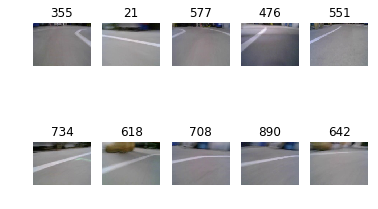

In [6]:
test_gen.reset(shuffle=False)
batch = test_gen.get_next_batch()
images   =  batch["images"]
steering = [ele["steering"] for ele in batch["annotations"]]
throttle = [ele["throttle"] for ele in batch["annotations"]]
names    = batch["names"]
print(f"{np.shape(images[:10])}")
for i, (im, st, th, na) in enumerate(zip(images[:10], steering[:10], throttle[:10], names[:10])):
    plot = i+1
    plt.subplot(2,5,plot)
    if np.shape(images)[3] == 1:
        plt.imshow(im[:,:,0])
    else:
        plt.imshow(im[:,:,])
    plt.axis('off')
    angle = st
    #plt.title("bin:{}".format(int(angle)))
    plt.title(f"{st}")
print(min(steering))

(10, 120, 160, 3)


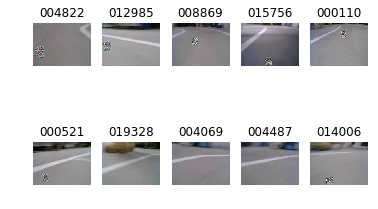

In [7]:
noisy_images   =  batch["noisy_images"]
steering = [ele["steering"] for ele in batch["annotations"]]
throttle = [ele["throttle"] for ele in batch["annotations"]]
names    = batch["names"]
print(f"{np.shape(noisy_images[:10])}")
for i, (im, st, th, na) in enumerate(zip(noisy_images[:10], steering[:10], throttle[:10], names[:10])):
    plot = i+1
    plt.subplot(2,5,plot)
    if np.shape(images)[3] == 1:
        plt.imshow(im[:,:,0])
    else:
        plt.imshow(im[:,:,])
    plt.axis('off')
    angle = st
    #plt.title("bin:{}".format(int(angle)))
    plt.title(f"{na[5:]}")



### Some hyperparams

In [8]:
from show_graph import show_graph
import autoencoder as model
from freeze_graph import freeze_meta

train_gen.reset()
test_gen.reset()
vae = model.Model(in_shape=[120,160,3],
                  lr=0.001,
                  embedding_dim=50,
                  num_projections=20)

### Train and Test Generators

# !!!!!!!!!!!!!!!! --- Run The Model --- !!!!!!!!!!!!!!!!

In [ ]:
epochs = 100
annealing_epochs=10
return_info = vae.train(train_gen=train_gen,
                        test_gen=test_gen,
                        save_dir = "delete_me_2",
                        epochs=epochs,
                        sample_inf_gen=sample_gen)
               
frozen_meta = freeze_meta(return_info["graph_path"],
                                    return_info["ckpt_path"],
                                    return_info["out_path"]+"/frozen.pb",
                                    return_info["tensor_json"])
return_info["frozen_meta"] = frozen_meta

In [ ]:
#from generator import DataGenerator as gen
from generator import  DenoisingVaeGenerator as gen

# For training (WILL bin steering annos, and WILL normalize throttle)           
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
#from generator import preprocess_normalize_images_bin_annos as process_fn       
#from generator import prepare_batch_images_and_labels_RAND_MIRROR as prep_batch 
                                                                                
# For evaluation (will NOT bin steering annos, and will leave throttle 0-1024)  
# Images are normalized                                                         
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
from generator import preprocess_normalize_images_only as process_fn           
from generator import prepare_batch_images_and_labels_NO_MIRROR as prep_batch

base_dir      = '../data/clr_120_160/'
image_dir     = base_dir + 'images/'
noisy_image_dir     = base_dir + 'noisy/'
anno_dir      = base_dir + 'annotations/'
test_path  = '../data/evened_test.txt'

raw_test = load_dataset(test_path)


# test_gen=gen(batch_size=50, 
#              data_set=raw_test[:1000],
#              image_dir=image_dir,
#              anno_dir=anno_dir,
#              preprocess_fn=process_fn,
#              prepare_batch_fn=prep_batch)

test_gen=gen(batch_size=batch_size, 
             data_set=raw_test[:100],
             image_dir=image_dir,
             noisy_dir=noisy_image_dir,
             anno_dir=anno_dir,
             preprocess_fn=process_fn,
             prepare_batch_fn=prep_batch)


### Plot the value for each element in the embedding vector wrt the steering angel to see if the $\beta$-vae has found any corrilation



In [35]:
'''
To select a model, update the MODEL_DIR variable
'''

import vae as model
from load_frozen import load_graph

test_gen.reset()                                               
t_test = trange(test_gen.steps_per_epoch)                     
t_test.set_description(f": Poop")

root_zeus = "/media/silverpond/development/home/josh/repos/FYP/fyp_diy_robo_car/car_vae"
autoencoder_zeus = root_zeus + "/my_autoencoder"
vae_zeus             = "/my_beta_1_vae"
beta_5_vae_zeus      = "/my_beta_vae"
beta_5_vae_300_zeus  = "/beta_vae_5_300"
beta_1_vae_300_zeus  = "/beta_vae_1_300"
autoencoder_300_zeus = "/300_autoencoder"
beta_0_01_vae_100    = "/vae_vary_betas/0_01"
beta_0_1_vae_100     = "/vae_vary_betas/0_1"
beta_1_vae_100       = "/vae_vary_betas/1"
beta_10_vae_100      = "/vae_vary_betas/10"
beta_100_vae_100     = "/vae_vary_betas/100"
deep_vae_b1_z20      = "/deep_vae_z20"
deep_vae_b1_z10      = "/deep_vae_z10"

world_vae              = "/vae_from_world_models"
noisy_world_vae        = "/noisy_vae_b1"
noisy_world_vae_b0_001 = "/noisy_world_vaes_increse_beta/0_001"
noisy_world_vae_b0_01  = "/noisy_world_vaes_increse_beta/0_01"
noisy_world_vae_b0_1   = "/noisy_world_vaes_increse_beta/0_1"
noisy_world_vae_b5     = "/noisy_world_vaes_increse_beta/5"
noisy_world_vae_b10    = "/noisy_world_vaes_increse_beta/10"
noisy_world_vae_b100   = "/noisy_world_vaes_increse_beta/100"

#################################
MODEL_DIR = root_zeus + noisy_world_vae
#################################

tensor_lookup_path = MODEL_DIR + "/tensor_names.json"
frozen_graph_path  = MODEL_DIR + "/frozen.pb"

tensor_lookup = json.load(open(tensor_lookup_path))

# IF YOU JUST COMPLETED A TRAINING RUN
#print(f"tensor_json at: {return_info['tensor_json']}")
#print(f"frozen_meta at: {return_info['frozen_meta']}")
#frozen_graph_path = return_info["frozen_meta"]
#tensor_lookup = json.load(open(return_info["tensor_json"]))

prefix = "model"
graph = load_graph(frozen_graph_path, prefix)
x_tens        = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.INPUTS][model.IMAGE_INPUT])
embedding_tens = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.OUTPUTS][model.EMBEDDING])
reconstruction_tens = graph.get_tensor_by_name(prefix+"/"+tensor_lookup[model.OUTPUTS][model.RECONSTRUCTION])

GPU_OPTIONS = tf.GPUOptions(per_process_gpu_memory_fraction=2/11)

'''
Be sure to check the feed_dict is accepting the correct image type for your needs:
  images or noisy_images
  
- Uncomment 100's and 1000's block to add more noise
'''
with tf.Session(graph=graph, config=tf.ConfigProto(gpu_options=GPU_OPTIONS)) as sess:
    ims      = {"originals" : [], "reconstructions" : [], "embeddings" : [], "noisy": []}
    annos    = {"steering"  : [], "throttle"  : []}
    for step in t_test:                       
        images, noisy_images, st_annos, th_annos = model.prepare_data(test_gen)
        
        ############# 100's and 1000's BLOCK  #############
        noise = np.random.choice([1, 0], size=np.prod(np.shape(images)), p=[0.7, 0.3])
        noise = np.reshape(noise, np.shape(images))
        noisy_images *= noise
        ###################################################
        
        emb, rec = sess.run([embedding_tens, reconstruction_tens],
                                           feed_dict={x_tens: noisy_images})
        ims["originals"].extend(images)
        ims["noisy"].extend(noisy_images)
        ims["embeddings"].extend(emb)
        ims["reconstructions"].extend(rec)
        annos["steering"].extend(st_annos)
        annos["throttle"].extend(th_annos)    


: Poop: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


(120, 1600, 3)
/media/silverpond/development/home/josh/repos/FYP/fyp_diy_robo_car/car_vae/noisy_vae_b1/side_by_side.jpg


/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


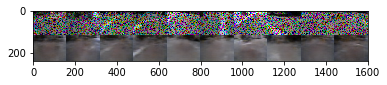

In [36]:
'''
Be sure to check the feed_dict is accepting the correct image type for your needs:
  images or noisy_images
  
'''
import scipy.misc

count = 10

save_dir = MODEL_DIR
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
path = save_dir + "/side_by_side.jpg"
full_image = []
idx = 0
orig  = np.concatenate(ims["noisy"][:count], axis=1)
recon = np.concatenate(ims["reconstructions"][:count], axis=1)
print(np.shape(orig))
combined = np.concatenate([orig, recon],axis=0)
plt.imshow(combined)
scipy.misc.toimage(combined, cmin=0.0, cmax=1.0).save(path)
print(path)

In [12]:
np.shape(ims["embeddings"])
average_embedding = np.mean(ims["embeddings"], axis=0)
np.shape(average_embedding)
print(average_embedding)
em_T = np.array(ims["embeddings"]).T
ave_range = []
for ele, row in enumerate(em_T):
    rng = max(row) - min(row)
    print(f"{ele}: range: {rng:.03f}")
    ave_range.append(rng)
print(f"ave range: {np.mean(ave_range):.3f}")

[ 0.69136864  0.16440485 -1.1903679   0.06389292  0.3505015  -0.7586615
  0.3094519  -0.9278429  -1.009978   -0.7475259  -0.47147915  1.8326905
 -0.01441823  1.3284047   0.46859777 -0.45277217 -6.6150804  -0.66759545
 -0.7549872   0.01254929 -0.41159067  0.01867483  1.3694258   0.11313198
 -0.58419114 -1.4714775  -0.41959774  2.5058274  -0.05057993  0.13640136
  0.33054328 -0.2935162  -1.4471446   0.5386013  -0.05334876 -1.4325817
 -0.28744948  0.43741608  1.1579144   0.13177581  0.42118305 -1.8057479
  2.0800085   0.7263906  -0.13359192 -1.0550183  -1.4479562  -0.9471541
  1.0282809   1.0318182 ]
0: range: 4.749
1: range: 4.424
2: range: 4.772
3: range: 5.135
4: range: 4.898
5: range: 4.687
6: range: 4.590
7: range: 6.398
8: range: 4.146
9: range: 5.022
10: range: 5.412
11: range: 3.442
12: range: 4.686
13: range: 4.887
14: range: 5.210
15: range: 3.563
16: range: 7.662
17: range: 3.826
18: range: 5.502
19: range: 7.668
20: range: 4.136
21: range: 5.294
22: range: 7.612
23: range: 4.8

Text(0.5,0.98,'Steering (x) with respet to embedding (y)')

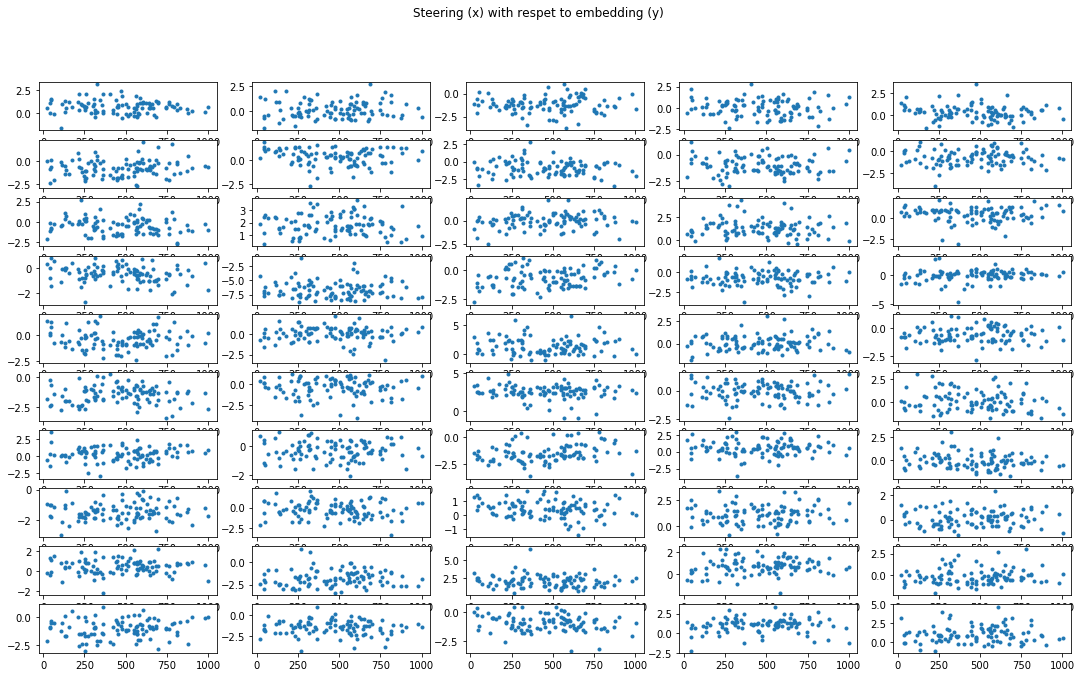

In [13]:
"""
Transpose embedding vector so each row
corrisponds n examples of the same element.
Then plot the various annotations wrt that 
particular element of the embedding vector.
"""
EMBEDDING_DIM = len(average_embedding)
em_T = np.array(ims["embeddings"]).T
steering = annos["steering"]
plot = 1
for row in em_T:
    plt.subplot(10,5,plot)
    plt.plot(steering, row, '.')
    plot += 1
  #  plt.axis('off')
   # angle = st
#    plt.title("bin:{}".format(int(angle)))
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.suptitle("Steering (x) with respet to embedding (y)")

### Vary each element in the embedding vector to see if any reconstructions change in 'meaningful' ways

In [14]:
low = -6.
high = 6.
step = 1
high += step  # arange is non-inclusive
steps = np.arange(low,high,step)
#base_embedding = np.zeros(50)
base_embedding = ims["embeddings"][20]
reconstructions = []
with tf.Session(graph=graph) as sess:
    for i in trange(EMBEDDING_DIM):
        batch = np.tile(base_embedding, (len(steps),1))
        batch[:,i] += steps
        recons = sess.run(reconstruction_tens,
                          feed_dict={embedding_tens: batch})
        reconstructions.extend(recons)
    print(np.shape(reconstructions))

100%|██████████| 50/50 [00:00<00:00, 161.89it/s]

(650, 120, 160, 3)


100%|██████████| 50/50 [00:00<00:00, 770.94it/s]
/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/ipykernel/__main__.py:18: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


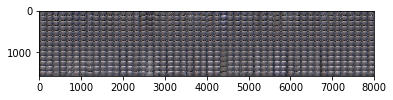

In [15]:
import scipy.misc

save_dir = MODEL_DIR
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

full_image = []
idx = 0
for ele in trange(EMBEDDING_DIM):
    single_ims = []
    for val in range(len(steps)):
        single_ims.append(reconstructions[idx])
        idx += 1
    col = np.concatenate(single_ims, axis=0)
    full_image.append(col)
full_image = np.concatenate(full_image, axis=1)
path = save_dir + f"/FULL_SET.jpg"
scipy.misc.toimage(full_image, cmin=0.0, cmax=1.0).save(path)
fig.set_size_inches(18.5, 10.5)
plt.imshow(full_image)


# Plot input image and reconstruction side by side

[-0.50210243  0.97186255  0.61876726  1.0292325  -0.24555817 -0.30078667
  1.3061001   0.3851773   0.5694808   0.2519904  -0.38993156  0.18470392
 -0.84821177  0.5158669  -0.42039764 -0.5470687   0.3347845  -0.8890586
  1.5765824  -0.22850414  0.09257475 -0.93854755  0.24332616 -2.8002982
  0.66836023 -0.37923956 -0.27992886  0.60870284 -0.429903    0.947822
 -0.9941489  -3.451625   -0.7996027   0.7176792   0.73521024  0.52719605
  0.9409777  -0.7745141  -1.8020247  -2.9644456   0.106076   -0.5904685
  1.4432957   0.81639194  0.37496513 -0.22354418 -0.5863611  -1.2060118
  0.2493493  -0.06827463]


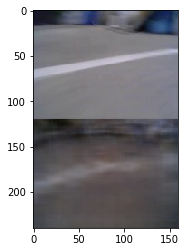

In [41]:
idx = 95
ori = ims["originals"][idx]
emb = ims["embeddings"][idx]
rec = ims["reconstructions"][idx]
c = np.concatenate((ori, rec), axis=0)
print(emb)
plt.imshow(c)

0.05568018
0.5082451


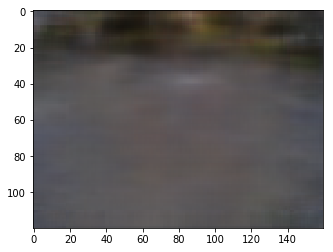

In [34]:

embedding = np.expand_dims(average_embedding, axis=0)
with tf.Session(graph=graph) as sess:
    recon = sess.run(reconstruction_tens,
                      feed_dict={embedding_tens: embedding})
    
plt.imshow(recon[0])
print(np.min(recon))
print(np.max(recon))

In [35]:
import scipy.misc
scipy.misc.toimage(recon[0], cmin=0.0, cmax=1.0).save('outfile_1.jpg')
#scipy.misc.imsave('outfile.jpg', recon[0])


/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  from ipykernel import kernelapp as app


In [48]:
a = np.ones((4,5,3))
b = np.zeros((4,5,3))
#h,w,c
c = np.concatenate((a, b, a), axis=0)
np.shape(c)

(12, 5, 3)

78
93


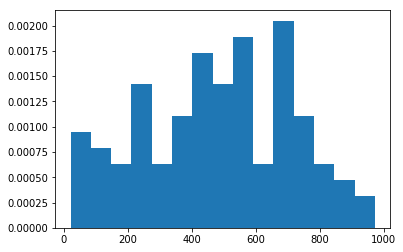

In [45]:
plt.hist(annos["steering"], 15, density=True)

start = None
end   = None
for idx, an in enumerate(annos["steering"]):
    if abs(an-900) < 10: start = idx
    if abs(an-100) < 30: end = idx
print(start)
print(end)

/home/josh/anaconda3/envs/py3_tf16/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


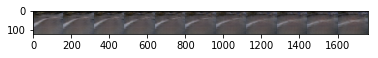

In [48]:
step_denominator = 10
start = 73
end = 95
increment = np.array(ims["embeddings"][end] - ims["embeddings"][start]) / step_denominator
embeds = []
for i in range(step_denominator+1):
    emb = ims["embeddings"][start] + (i*increment)
    embeds.append(emb)
with tf.Session(graph=graph) as sess:
    embeds = np.array(embeds)
    recons = sess.run(reconstruction_tens,
                      feed_dict={embedding_tens: embeds})

joined = np.concatenate(recons, axis=1)
plt.imshow(joined)
scipy.misc.toimage(joined, cmin=0.0, cmax=1.0).save('FDAJHFJHDFJHDSKJFHKJD.jpg')